### XGBoost

Basic Example of XGBoost Classifier implementation

## About the Data

In this Jupyter notebook, we will explore a dataset containing various features extracted from URLs. Each feature is associated with a label indicating the nature of the URL:

    Legitimate: 1,
    Suspicious: 0,
    Phishing: -1
    
Our goal is to develop a machine Learing Classifier model trained on this dataset to predict whether a given URL corresponds to a malicious website. Through this analysis, we aim to build a robust model capable of identifying potentially malicious URLs and enhancing cybersecurity measures.


Dataset Features:

    having_IP_Address
    URL_Length
    Shortining_Service
    having_At_Symbol
    double_slash_redirecting
    Prefix_Suffix
    having_Sub_Domain
    SSLfinal_State
    Domain_registeration_length
    Favicon
    port
    HTTPS_token
    Request_URL
    URL_of_Anchor
    Links_in_tags
    SFH
    Submitting_to_email
    Abnormal_URL
    Redirect
    on_mouseover
    RightClick
    popUpWidnow
    Iframe
    age_of_domain
    DNSRecord
    web_traffic
    Page_Rank
    Google_Index
    Links_pointing_to_page
    Statistical_report
    Result

## 1. Importing Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# for model creation and evaluation
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# for vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# supress warnings
import warnings
warnings.simplefilter('ignore')

## 2. Data Load & Overview

In [2]:
# importing data
data = pd.read_csv('../Data/PhishingWebsites.csv')

In [3]:
# creating a copy of the dataset to avoid permanent changes
df = data.copy()

In [4]:
# looking at the size of the dataset
print(f' *There are {df.shape[0]} observations')
print(f' *There are {df.shape[1]} variables including a dependant variable')

 *There are 11055 observations
 *There are 31 variables including a dependant variable


* All data is nominal
* feature values include:
    - 1: legitimate
    - 0: Suspicious
    - -1: Phishing

In [6]:
# looking at the distribution of dependent variable
df['Result'].value_counts()

Result
 1    6157
-1    4898
Name: count, dtype: int64

* Data is balanced
* Phishing websites make up for ~44% of the data

## 3. Data Preprocessing

Will transform target values from [-1, 1] to [0, 1] to align with XGBoost's binary classification requirement.


In [7]:
# converting the target variable to [0,1] instead of [-1,1]
df['Result'] = np.where(df['Result'] == -1, 0, df['Result'])

### 4. Model

* Build Model
* Evaluate Model
* Make predictions
* visualize model

In [8]:
# splitting data
X = df.drop('Result', axis=1) # independant variables
y = df['Result']                # dependant variable

# Splitting data 7:3 into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [9]:
# Defining model
model = XGBClassifier(random_state=123)

# Training model
model.fit(X_train, y_train);


### 4.2 Evaluate Model

* Checking Accuracy of model in both training and testing data

In [10]:
# function for looking at the performance of a classification model
def model_performance(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [11]:
# looking at performance metrics for training and testing data
display(model_performance(model,X_train,y_train))
display(model_performance(model,X_test,y_test))

,Accuracy,Recall,Precision,F1
0,0.988369,0.993303,0.986016,0.989646


,Accuracy,Recall,Precision,F1
0,0.968948,0.98139,0.962943,0.972079


Model returned high accuracy in both training and testing data, indicating there is no overfitting

## 4.3 Making a prediction

When using XGBoost predict, we have to pass the column names that were used for training along with the new values we want to use to make a prediction

In [12]:
# Define column names based on the training data
columns = X_train.columns.to_list()

# creating feature values for prediction
new_website_features = [[1,-1,1,1,1,1,1,1,1,1,
                         1,0,1,1,1,1,0,-1,0,0,
                         1,0,0,1,1,1,1,1,1,1]]

# Create a DataFrame with the provided features and column names
new_website_df = pd.DataFrame(new_website_features, columns=columns)

# making a prediction on the created feature DataFrame
pred = model.predict(new_website_df)

dict = {1:'Legitimate',0:'Phishing'}
print(f'Based on the entered values, the model predicts this is a {dict[pred[0]]} website')

Based on the entered values, the model predicts this is a Legitimate website


## 4.3.1 Describing performance of model predictions

In [13]:
# Function to display model confusion_matrix
def c_matrix(y_test,y_pred):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['Malicious', 'Legitimate'] )
    cm_display.plot()
    plt.show()

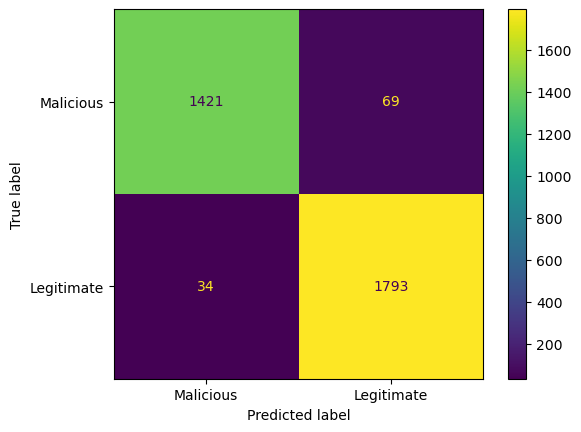

In [14]:
# getting predictions for the testing data
predictions = model.predict(X_test)

# creating confusion matrix
c_matrix(y_test,predictions)

Observations:

* 1421 True Positives: correctly predicted as positive (malicious)
* 1793 True Negatives: correctly predicted as negative (legitimate)
* 69 False Negativs: incorrectly predicted as negative
* 34 False Positives: incorrectly predicted as positive

## 5. Hyper Parameter Tuning

In [15]:

from sklearn.model_selection import  GridSearchCV


# Define XGBoost classifier
xgb_model = XGBClassifier()

# Define hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_xgb_model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Test accuracy: 0.9662345492915285


### 5.1 All hyper parameters

These are just a few of the parameters available in XGBoost. For a comprehensive list and detailed descriptions, you can refer to the official XGBoost documentation.